# Tutorial: Analyze Functional Dependencies in a PowerBI Sample Dataset

**Customer intent:** As a data scientist, I want to leverage prior work of PowerBI analyst that's preserved in the form of datasets and on top of it have ways to discover non-trivial issues with data quality automatically so that I can reclaim time for doing other important work while making my analytical insights even more accurate and trustworthy.

**Description:** This demo is focused on the analysis of functional dependencies in the Fabric's PowerBI environment. SemPy supports dependency analysis between columns of a dataframe.

**Authors@microsoft:** alsavelv, richwyd, marcozo, taniaarya

**Service/Product:** Fabric / Semantic Link

**Written:** 08/29/2023

### In this tutorial, you learn how to:
- Apply domain knowledge to formulate hypothesis about functional dependencies in a dataset;
- Get familiarized with components of Semantic Link's Python library named SemPy that support integration with PowerBI and help automate data quality analysis, such as
    - FabricDataFrame - a pandas-like structure enhanced with additional semantic information;
    - Useful functions for pulling PBI datasets from a Fabric workspace into your notebook;
    - Useful functions that automated evaluation of hypothesis about functional dependencies and identify violations.

### Prerequisites
1.	A Premium Power BI subscription.   
2.	A Power BI Workspace with assigned premium capacity.
3.	An existing "Customer Profitability Sample PBIX" pre-uploaded to the workspace before executing the notebook code.

## Setup the notebook

Firstly, we install SemPy from PyPI using pip magic command:

In [1]:
%pip install semantic-link

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.9 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 120.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.3/754.3 kB 135.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 116.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 74.5 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 177.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 152.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: /nfs4/pyenv-429011be-8e8c-4e3c-a3fb-d250c45c7f80/bin/python -m pip install --upgrade

Then we perform necessary imports of modules that will be needed later on:

In [11]:
import sempy.fabric as fabric

from sempy.dependencies import plot_dependency_metadata

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 20, Finished, Available)

## Load and preprocess data

This demo relies on a standard PowerBI sample dataset from https://learn.microsoft.com/en-us/power-bi/create-reports/sample-customer-profitability. Let's start from loading the PBI data into dataframes using SemPy's ``read_table`` function:

In [4]:
dataset = "Customer Profitability Sample PBIX"
customer = fabric.read_table(dataset, "Customer")
customer.head()

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 13, Finished, Available)

,Customer,Country/Region,Name,City,Postal Code,State,Industry ID
0,1023,US,Spade and Archer,Irving,75038,TX,31
1,10000,US,Globo-Chem,Chicago,60601,IL,30
2,10001,US,SNC Directly to America,Westchester,60154,IL,30
3,10002,US,GHG,Plano,75024,TX,13
4,10003,US,ABC Helicopter,Fort Worth,76177,TX,34


Then we do the same for table called 'State':

In [6]:
state = fabric.read_table(dataset, "State")
state.head()

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 15, Finished, Available)

,StateCode,State,Region
0,AK,ALASKA,WEST
1,FL,FLORIDA,EAST
2,GA,GEORGIA,EAST
3,HI,HAWAII,WEST
4,IA,IOWA,NORTH


While the output looks like pandas dataframe, but actually we initialized data structures called ``FabricDataFrame`` that support some useful operations on top of pandas.

In [7]:
type(customer)

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 16, Finished, Available)

sempy.fabric._dataframe._fabric_dataframe.FabricDataFrame

Let's join Customer and State tables:

In [8]:
customer_state_df = customer.merge(state, left_on="State", right_on="StateCode",  how='left')
customer_state_df.head()

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 17, Finished, Available)

,Customer,Country/Region,Name,City,Postal Code,State_x,Industry ID,StateCode,State_y,Region
0,1023,US,Spade and Archer,Irving,75038,TX,31,TX,TEXAS,SOUTH
1,10000,US,Globo-Chem,Chicago,60601,IL,30,IL,ILLINOIS,NORTH
2,10001,US,SNC Directly to America,Westchester,60154,IL,30,IL,ILLINOIS,NORTH
3,10002,US,GHG,Plano,75024,TX,13,TX,TEXAS,SOUTH
4,10003,US,ABC Helicopter,Fort Worth,76177,TX,34,TX,TEXAS,SOUTH


## Identify functional dependencies

A functional dependency manifests itself as a one-to-many relationship between the values in two (or more) columns within a dataframe (which does not occur if the dataset adheres to 3rd normal form). These relationships can be instrumental for automatic detection of data quality problems. Will SemPy help us identify functional dependencies between values in the columns? Let's try running ``find_dependencies`` function on the merged dataframe:

In [9]:
dependencies = customer_state_df.find_dependencies()
dependencies

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 18, Finished, Available)

,determinant,dependent,conditional_entropy,determinant_n_unique,dependent_n_unique,determinant_n_nulls,dependent_n_nulls
0,Customer,Name,0.000000,327,303,0,0
1,Customer,Postal Code,0.000000,327,208,0,50
2,Customer,City,0.000000,327,188,0,0
3,Customer,State_x,0.000000,327,37,0,0
4,Customer,Industry ID,0.000000,327,32,0,0
5,Name,Country/Region,0.004239,303,4,0,0
6,State_x,"[StateCode, State_y]",0.000000,37,34,0,13
7,State_x,Country/Region,0.000000,37,4,0,0
8,"[StateCode, State_y]",Region,0.000000,34,6,13,13


We visualize identified dependencies below using another SemPy's function, ``plot_dependency_metadata``:

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 21, Finished, Available)

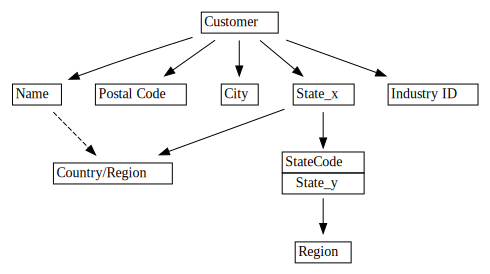

In [12]:
plot_dependency_metadata(dependencies)

Let's explore: it's bizarre that we didn't detect functional dependencies between  City and postal code. There probably are many violations. Another handy funciton of SemPy, ``plot_dependency_violations``, allows to visualize violations of dependencies between speficied columns:

## Explore data for quality issues

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 22, Finished, Available)

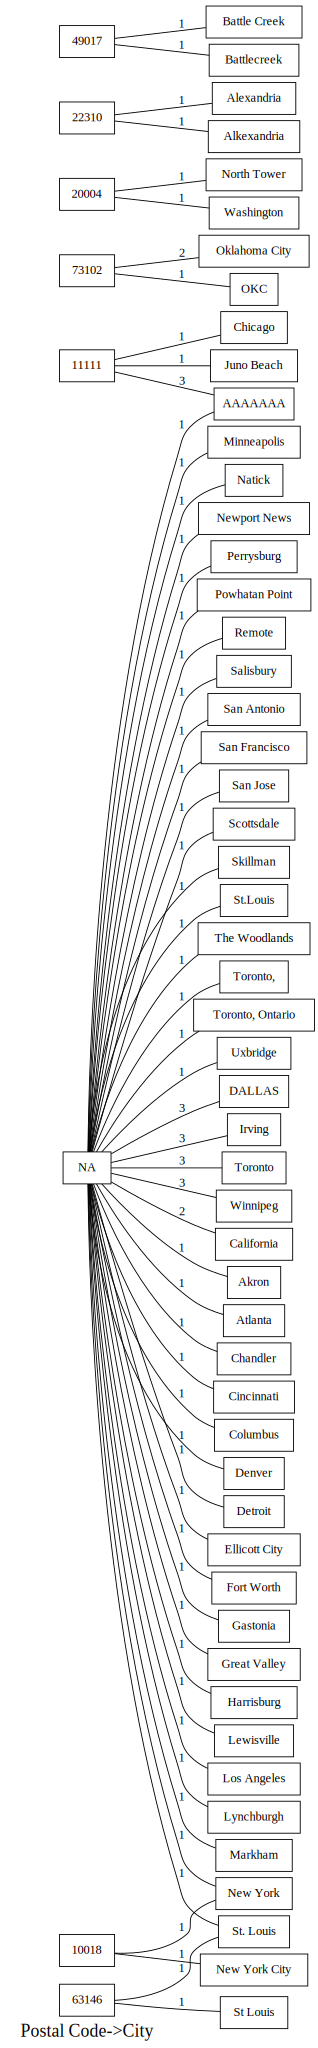

In [13]:
customer_state_df.plot_dependency_violations('Postal Code', 'City')

Indeed, quite a few violations. Moreover, there are many empty values.

In [14]:
customer_state_df['Postal Code'].isna().sum()

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 23, Finished, Available)

50

50 rows have NA for postal code, to be precise. Let's try to detect dependencies after getting rid of empty values. Note that we pass an additional parameter to ``find_dependencies`` function,  ``verbose=1``, in order to get a glimpse at the internal workings of SemPy:

In [16]:
customer_state_df2=customer_state_df.dropna()
customer_state_df2.find_dependencies(verbose=1)

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 25, Finished, Available)

State_x, StateCode: nunique 33, 33
Mapping size 33, dependency: True
State_x, State_y: nunique 33, 33
Mapping size 33, dependency: True

Dependencies for 10 columns 8 groups 275 rows, dropna=False, threshold=0.01
Region, Country/Region: cardinality shortcut: 0.0, 1.0
Region, Country/Region: conditional entropy 0.0, 1.0
Industry ID, Region: cached calculation 2.9751958829576504, 1.4548338980405395, 0.35134562333349867
Industry ID, Region: conditional entropy 1.103488274707041, 2.6238502596241515
Industry ID, Country/Region: cardinality shortcut: 0.0, 1.0
Industry ID, Country/Region: conditional entropy 0.0, 1.0
State_x, Industry ID: cached calculation 2.9883008304144907, 2.9751958829576504, 1.1575667522391768
State_x, Industry ID: conditional entropy 1.8176291307184735, 1.8307340781753139
State_x, Region: cached calculation 2.9883008304144907, 1.4548338980405395, 1.4548338980405395
State_x, Region: conditional entropy 0.0, 1.5334669323739512
State_x, Country/Region: indirectly dependent

,determinant,dependent,conditional_entropy,determinant_n_unique,dependent_n_unique,determinant_n_nulls,dependent_n_nulls
0,Customer,Name,0.0,275,256,0,0
1,Customer,Postal Code,0.0,275,205,0,0
2,Customer,City,0.0,275,165,0,0
3,Customer,"[State_x, StateCode, State_y]",0.0,275,33,0,0
4,Customer,Industry ID,0.0,275,32,0,0
5,Name,Country/Region,0.0,256,1,0,0
6,Postal Code,Country/Region,0.0,205,1,0,0
7,City,Country/Region,0.0,165,1,0,0
8,"[State_x, StateCode, State_y]",Region,0.0,33,5,0,0
9,Industry ID,Country/Region,0.0,32,1,0,0


Now conditional entropy is 0.049, which makes sense, since we saw violations. We can fix violations. But before we do, just to see the dependencies, we can explicitly raise the threshold as follows:

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 26, Finished, Available)

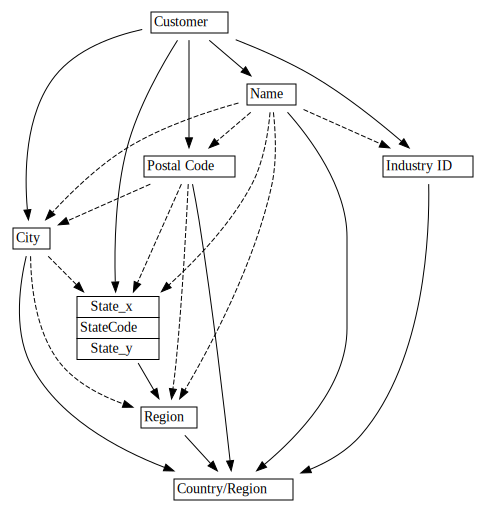

In [17]:
plot_dependency_metadata(customer_state_df2.find_dependencies(threshold=0.05))

When we come to think from the domain perspective about which entity should determine values of other entities, this graph seems accurate. Let's explore more data quality issues that we detected. For example, what's going on with City and Region that causes the line to be dotted, implying existence of partial functional dependencies?

In [18]:
customer_state_df.list_dependency_violations('City', 'Region')

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 27, Finished, Available)

,City,Region,count
0,AAAAAAA,SOUTH,3
1,AAAAAAA,NaN,1
2,Downers Grove,CENTRAL,1
3,Downers Grove,NORTH,1
4,Fremont,SOUTH,1
5,Fremont,WEST,1
6,Uxbridge,EAST,1
7,Uxbridge,NaN,1


Going deeper into each of the cases where we see non-empty Region value that causes violations:

In [19]:
customer_state_df[customer_state_df.City=='Downers Grove']

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 28, Finished, Available)

,Customer,Country/Region,Name,City,Postal Code,State_x,Industry ID,StateCode,State_y,Region
66,10114,US,SNC Downers Grove,Downers Grove,60515,NE,30,NE,NEBRASKA,CENTRAL
249,50128,US,SNC Downers Grove,Downers Grove,60515,IL,30,IL,ILLINOIS,NORTH


Downers Grove definitely is in Illinois, not Nebraska. See wiki: https://en.wikipedia.org/wiki/Downers_Grove,_Illinois ("It was founded in 1832 by Pierce Downer, whose surname serves as the eponym for the village"). Great catch of data consistency issue!

In [20]:
customer_state_df[customer_state_df.City=='Fremont']

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 29, Finished, Available)

,Customer,Country/Region,Name,City,Postal Code,State_x,Industry ID,StateCode,State_y,Region
37,10036,US,Horn BPO,Fremont,94555,TX,30,TX,TEXAS,SOUTH
46,10060,US,Soneli Graphics,Fremont,94538,CA,13,CA,CALIFORNIA,WEST


There is a city called Fremont in California (https://en.wikipedia.org/wiki/Fremont,_California). However, for Texas, the search engine returns Premont, not Fremont (https://en.wikipedia.org/wiki/Premont,_Texas)! Interesting error in the data, and really awesome that we were able to catch it automatically :)

It's also suspicious to see violations of "Name" and "Country/Region" depencency, signified by dotted line.

In [21]:
customer_state_df.list_dependency_violations('Name', 'Country/Region')

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 30, Finished, Available)

,Name,Country/Region,count
0,SDI Design,CA,1
1,SDI Design,US,1


Seems like have one customer, 'SDI Design' who's present in two regions - United States and Canada. This doesn't  look like a semantic violation, just an uncommon case, but let's take a closer look at them:

In [22]:
customer_state_df[customer_state_df.Name=='SDI Design']

StatementMeta(, 2fda03cc-9670-47e6-b550-331b4ad096c1, 31, Finished, Available)

,Customer,Country/Region,Name,City,Postal Code,State_x,Industry ID,StateCode,State_y,Region
128,10203,US,SDI Design,Denver,80222,CO,15,CO,COLORADO,CENTRAL
323,50233,CA,SDI Design,Winnipeg,<NA>,MB,30,NaN,NaN,NaN


It's actually different customers with the same name - coming different industries. It doesn't seem wrong, just a collision of names.

Exploratory data analysis is an exciting process, and so is data cleaning. There's always something that the data is hiding, depending on how you look at it, what you want to ask, and so on. We are hoping that with the new tools you'll be able to achieve more. 

## Clean up resources
If you are not going to use this tutorial after completion, you may now delete it from the workspace.

## Next step

Try using the learned ways of detecting data quality issues on your data and get amazed with the discoveries!

## Related content

Check out other tutorials for Semantic Link / SemPy:
1. Clean Data with Functional Dependencies
1. Detect Relationships in SYNTHEA dataset
1. Detect Relationships in a PowerBI Sample Dataset
1. Extract and Calculate PowerBI Measures from Jupyter Notebook